In [1]:
# ========= Install Required Packages =========
# !pip install transformers librosa soundfile tqdm torch torchaudio --quiet

# ========= Imports =========
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import gc
from transformers import BlipProcessor, BlipForConditionalGeneration
from sklearn.model_selection import train_test_split

# ========= Device =========
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ========= 1. Load CSV =========
csv_path = "/kaggle/input/correctimgaud/image_caption_audio_triplets_fixed.csv"
df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)

# ========= 2. Split Data =========
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = train_df.to_dict(orient='records')
test_dataset = test_df.to_dict(orient='records')
audio_root = "/kaggle/input/wavoutput"

# ========= 3. BLIP Dataset =========
class BLIPImageDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item['img']).convert("RGB")
        encoding = self.processor(images=image, text=item['caption'], 
                                  padding="max_length", return_tensors="pt", truncation=True)
        encoding = {k: v.squeeze() for k,v in encoding.items()}
        return encoding

# ========= 4. Audio Dataset =========
class BLIPAudioDataset(Dataset):
    def __init__(self, dataset, processor, audio_root, n_mels=80, fixed_frames=64):
        self.dataset = dataset
        self.processor = processor
        self.audio_root = audio_root
        self.n_mels = n_mels
        self.fixed_frames = fixed_frames

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item['img']).convert("RGB")
        encoding = self.processor(images=image, text=item['caption'], 
                                  padding="max_length", return_tensors="pt", truncation=True)
        encoding = {k: v.squeeze() for k,v in encoding.items()}

        # Load audio
        wav_path = os.path.join(self.audio_root, item['audio'])
        waveform, sr = torchaudio.load(wav_path)
        waveform = waveform.mean(dim=0, keepdim=True)
        mel = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=self.n_mels, n_fft=1024, hop_length=256)(waveform)
        mel = torchaudio.transforms.AmplitudeToDB()(mel)
        T = mel.shape[-1]
        if T < self.fixed_frames:
            mel = F.pad(mel, (0, self.fixed_frames - T))
        else:
            mel = mel[:, :, :self.fixed_frames]

        return encoding, mel

# ========= 5. Load BLIP Model =========
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# ========= 6. BLIP Training =========
train_blip_dataset = BLIPImageDataset(train_dataset, processor)
train_blip_loader = DataLoader(train_blip_dataset, batch_size=4, shuffle=True)

optimizer = optim.AdamW(blip_model.parameters(), lr=5e-5)
epochs = 3  # small first for testing

blip_model.train()
for epoch in range(epochs):
    total_loss = 0
    with tqdm(total=len(train_blip_loader), desc=f"BLIP Epoch {epoch+1}/{epochs}") as pbar:
        for batch in train_blip_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = blip_model(input_ids=input_ids,
                                 pixel_values=pixel_values,
                                 labels=input_ids,
                                 attention_mask=attention_mask)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    print(f"BLIP Epoch {epoch+1} - Avg Loss: {total_loss/len(train_blip_loader):.4f}")

# Save trained BLIP
blip_model.save_pretrained("trained_blip_model")
processor.save_pretrained("trained_blip_processor")
torch.cuda.empty_cache()
gc.collect()

# ========= 7. Audio Generator =========
class ImageToAudioGenerator(nn.Module):
    def __init__(self, img_feat_dim=768, mel_bins=80, hidden_dim=256):
        super().__init__()
        self.img_proj = nn.Linear(img_feat_dim, hidden_dim)
        self.encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.decoder_rnn = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True)
        self.mel_proj = nn.Linear(hidden_dim//2, mel_bins)

    def forward(self, img_feats, max_frames=64):
        batch_size = img_feats.size(0)
        img_feats = self.img_proj(img_feats)
        img_feats = self.encoder(img_feats)
        encoder_out = img_feats.unsqueeze(1)
        h0 = torch.zeros(1, batch_size, img_feats.size(-1)//2, device=img_feats.device)
        c0 = torch.zeros(1, batch_size, img_feats.size(-1)//2, device=img_feats.device)
        mel_outputs = []
        decoder_input = torch.zeros(batch_size, 1, img_feats.size(-1), device=img_feats.device)
        for _ in range(max_frames):
            attn_out, _ = self.attention(decoder_input, encoder_out, encoder_out)
            lstm_out, (h0, c0) = self.decoder_rnn(attn_out, (h0, c0))
            mel_frame = self.mel_proj(lstm_out)
            mel_outputs.append(mel_frame)
            decoder_input = lstm_out.repeat(1,1,2)
        mel_outputs = torch.cat(mel_outputs, dim=1)
        return mel_outputs.transpose(1,2).unsqueeze(1)

# Simple vocoder
class WaveRNNVocoder(nn.Module):
    def __init__(self, mel_bins=80, hidden_dim=64):
        super().__init__()
        self.conv_up = nn.Conv1d(mel_bins, hidden_dim, kernel_size=3, padding=1)
        self.rnn = nn.GRU(hidden_dim, hidden_dim//2, batch_first=True)
        self.output_proj = nn.Linear(hidden_dim//2, 1)

    def forward(self, mel_spec):
        mel_spec = mel_spec.squeeze(1)
        upsampled = self.conv_up(mel_spec).transpose(1,2).repeat_interleave(32, dim=1)
        if upsampled.size(1) > 1024:
            upsampled = upsampled[:, :1024, :]
        rnn_out, _ = self.rnn(upsampled)
        audio = torch.tanh(self.output_proj(rnn_out)).squeeze(-1)
        return audio

# ========= 8. Audio Training =========
train_audio_dataset = BLIPAudioDataset(train_dataset, processor, audio_root)
train_audio_loader = DataLoader(train_audio_dataset, batch_size=2, shuffle=True)

audio_generator = ImageToAudioGenerator().to(device)
vocoder = WaveRNNVocoder().to(device)
optimizer = optim.AdamW(list(audio_generator.parameters()) + list(vocoder.parameters()), lr=5e-5)
loss_fn = nn.MSELoss()

# Freeze BLIP during audio training
blip_model.eval()

for epoch in range(3):
    total_loss = 0
    with tqdm(total=len(train_audio_loader), desc=f"Audio Epoch {epoch+1}/3") as pbar:
        for batch in train_audio_loader:
            optimizer.zero_grad()
            encoding, mels = batch
            # Get image embeddings from BLIP
            with torch.no_grad():
                pixel_values = encoding['pixel_values'].to(device)
                img_feats = blip_model.vision_model(pixel_values).pooler_output

            mels = mels.to(device)
            pred_mels = audio_generator(img_feats, max_frames=mels.shape[-1])
            pred_audio = vocoder(pred_mels)
            gt_audio = vocoder(mels)
            min_len = min(pred_audio.shape[1], gt_audio.shape[1])
            loss = loss_fn(pred_audio[:, :min_len], gt_audio[:, :min_len])

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    print(f"Audio Epoch {epoch+1} - Avg Loss: {total_loss/len(train_audio_loader):.4f}")

# Save audio generator
torch.save(audio_generator.state_dict(), "audio_generator.pth")
torch.save(vocoder.state_dict(), "vocoder.pth")


2025-08-16 02:05:05.266351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755309905.289285      83 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755309905.296205      83 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device: cuda
Dataset shape: (8475, 4)


BLIP Epoch 1/3: 100%|██████████| 1907/1907 [23:20<00:00,  1.36it/s, loss=0.0696]


BLIP Epoch 1 - Avg Loss: 0.2434


BLIP Epoch 2/3: 100%|██████████| 1907/1907 [23:13<00:00,  1.37it/s, loss=0.0143]


BLIP Epoch 2 - Avg Loss: 0.0265


BLIP Epoch 3/3: 100%|██████████| 1907/1907 [23:11<00:00,  1.37it/s, loss=0.0147]


BLIP Epoch 3 - Avg Loss: 0.0169


Audio Epoch 1/3: 100%|██████████| 3814/3814 [16:22<00:00,  3.88it/s, loss=0.0003]


Audio Epoch 1 - Avg Loss: 0.0097


Audio Epoch 2/3: 100%|██████████| 3814/3814 [16:23<00:00,  3.88it/s, loss=0.0004]


Audio Epoch 2 - Avg Loss: 0.0019


Audio Epoch 3/3: 100%|██████████| 3814/3814 [16:27<00:00,  3.86it/s, loss=0.0001]

Audio Epoch 3 - Avg Loss: 0.0008


Evaluation Device: cuda
Dataset shape: (8475, 4)
Test set size: 848
Loading trained models...
✓ BLIP model loaded successfully
✓ Audio models loaded successfully

EVALUATING BLIP MODEL


Evaluating BLIP: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



BLIP Evaluation Results:
Average BLEU Score: 0.3399
Average METEOR Score: 0.4878

Sample Caption Results:

Example 1:
Ground Truth: A plane flying over the water at sunset
Generated:    a large passenger jet flying through a pink cloud filled sky.
BLEU:         0.0257

Example 2:
Ground Truth: A woman walking across the street looking at a Car Quest vehicle.
Generated:    a street scene with a woman crossing at the crosswalk.
BLEU:         0.0614

Example 3:
Ground Truth: The black cat is alert, lying in front of the bathroom sink.
Generated:    a black cat drinking water from a bathroom sink.
BLEU:         0.0641

EVALUATING AUDIO GENERATION


Evaluating Audio Generation:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s]

Error processing audio sample 0: Error opening 'generated_audio_samples/gt_audio_0.wav': Format not recognised.


Evaluating Audio Generation:  10%|█         | 2/20 [00:00<00:01,  9.10it/s]

Error processing audio sample 1: Error opening 'generated_audio_samples/gt_audio_1.wav': Format not recognised.


Evaluating Audio Generation:  15%|█▌        | 3/20 [00:00<00:01,  9.25it/s]

Error processing audio sample 2: Error opening 'generated_audio_samples/gt_audio_2.wav': Format not recognised.


Evaluating Audio Generation: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]



Audio Generation Evaluation Results:
Average MSE: 0.001381
Average MAE: 0.022280
Average SNR (dB): 26.82
Average Spectral Convergence: 0.0433
Average Log Magnitude Error: 0.2742

GENERATING EVALUATION PLOTS
Generating image-caption comparison plots...


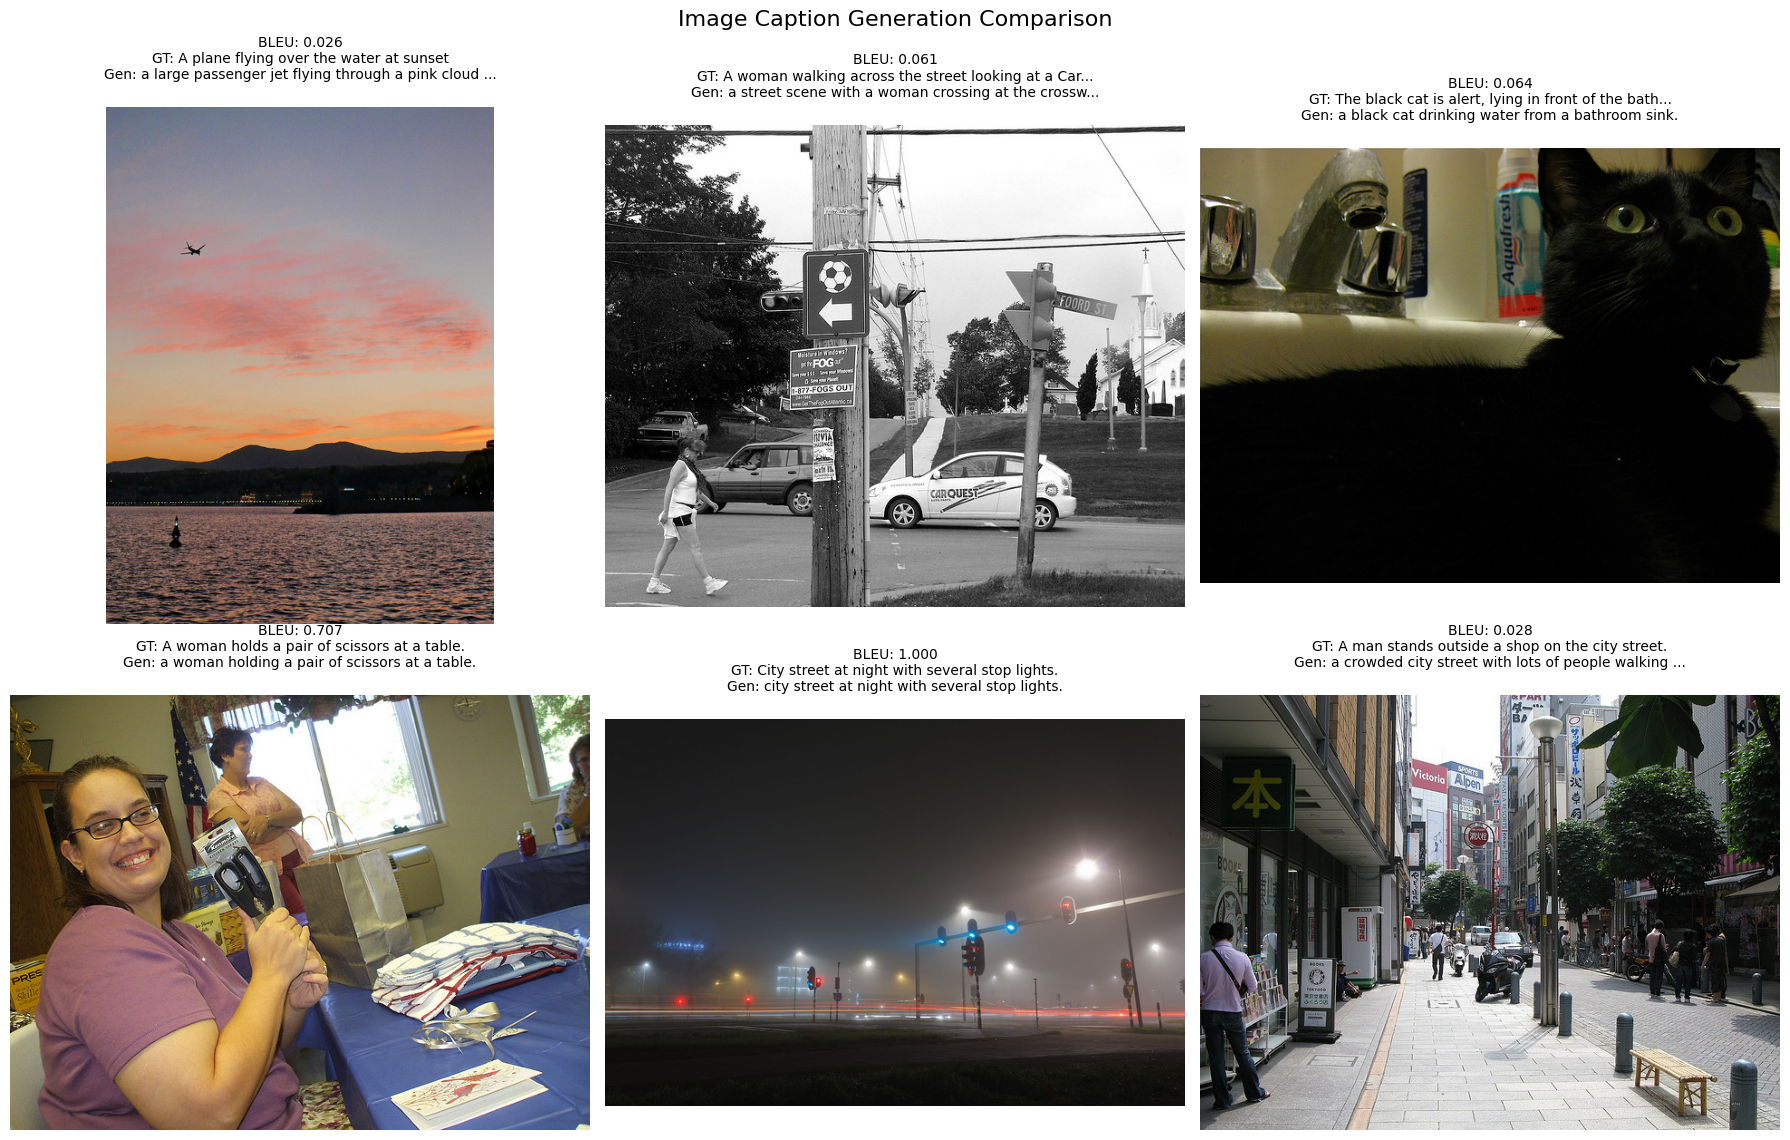

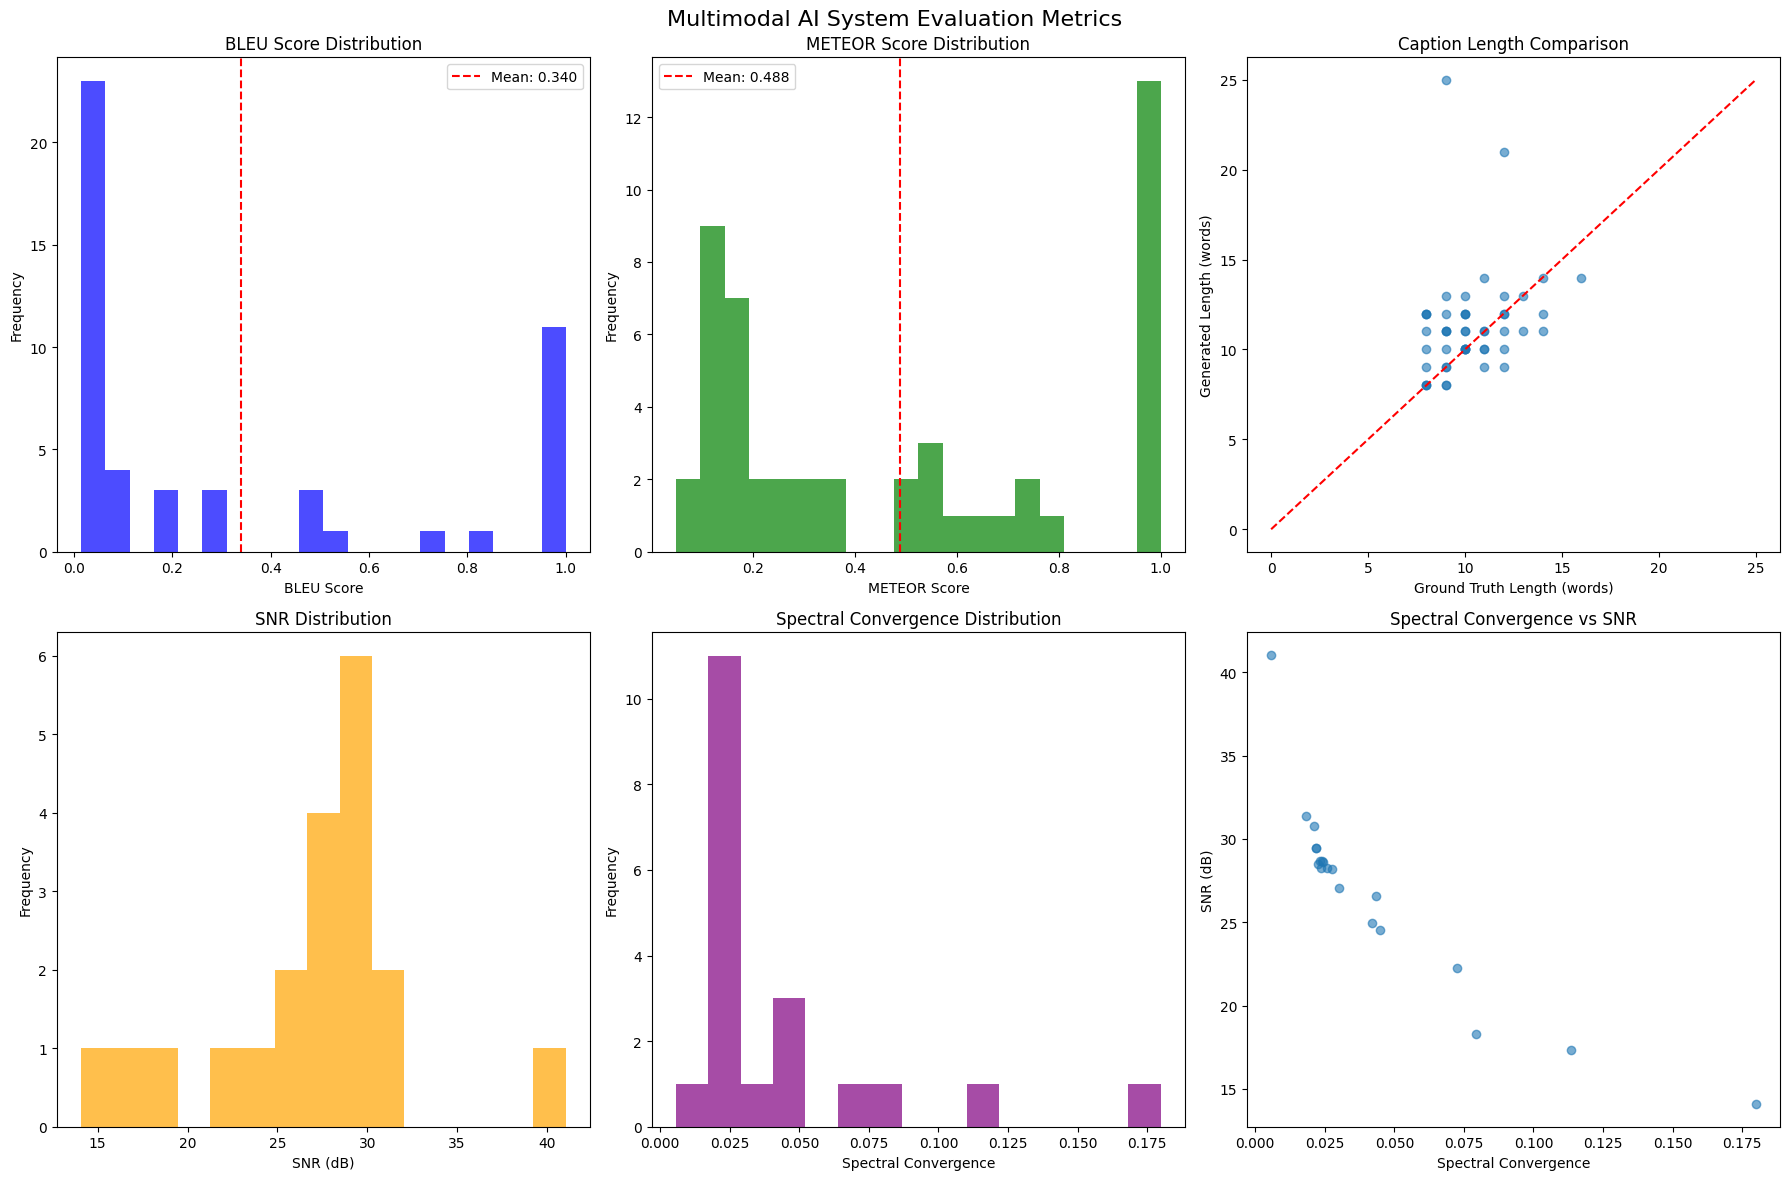


FINAL EVALUATION SUMMARY

📊 BLIP Model Performance:
   • BLEU Score:   0.3399 
   • METEOR Score: 0.4878 
   • Samples Evaluated: 50

🎵 Audio Generation Performance:
   • MSE:           0.001381 
   • MAE:           0.022280 
   • SNR:           26.82 dB 
   • Spectral Conv: 0.0433 
   • Log Mag Error: 0.2742 
   • Samples Evaluated: 20

EVALUATION COMPLETE!


In [9]:
# ========= Install Required Packages =========
# !pip install transformers librosa soundfile tqdm torch torchaudio matplotlib seaborn scikit-learn nltk --quiet

# ========= Imports =========
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import gc
from transformers import BlipProcessor, BlipForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

# NLTK imports for text evaluation
try:
    import nltk
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.translate.meteor_score import meteor_score
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    print("NLTK not available, skipping some text metrics")

# ========= Device =========
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Evaluation Device: {device}")

# ========= Load Data =========
csv_path = "/kaggle/input/correctimgaud/image_caption_audio_triplets_fixed.csv"
df = pd.read_csv(csv_path)
print(f"Dataset shape: {df.shape}")

# Use same split as training
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
test_dataset = test_df.to_dict(orient='records')
audio_root = "/kaggle/input/wavoutput"

print(f"Test set size: {len(test_dataset)}")

# ========= Dataset Classes (Same as training) =========
class BLIPImageDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item['img']).convert("RGB")
        encoding = self.processor(images=image, text=item['caption'], 
                                  padding="max_length", return_tensors="pt", truncation=True)
        encoding = {k: v.squeeze() for k,v in encoding.items()}
        return encoding, item['caption'], item['img']

class BLIPAudioDataset(Dataset):
    def __init__(self, dataset, processor, audio_root, n_mels=80, fixed_frames=64):
        self.dataset = dataset
        self.processor = processor
        self.audio_root = audio_root
        self.n_mels = n_mels
        self.fixed_frames = fixed_frames

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item['img']).convert("RGB")
        encoding = self.processor(images=image, text=item['caption'], 
                                  padding="max_length", return_tensors="pt", truncation=True)
        encoding = {k: v.squeeze() for k,v in encoding.items()}

        # Load audio
        try:
            wav_path = os.path.join(self.audio_root, item['audio'])
            waveform, sr = torchaudio.load(wav_path)
            waveform = waveform.mean(dim=0, keepdim=True)
            mel = torchaudio.transforms.MelSpectrogram(
                sample_rate=sr, n_mels=self.n_mels, n_fft=1024, hop_length=256
            )(waveform)
            mel = torchaudio.transforms.AmplitudeToDB()(mel)
            T = mel.shape[-1]
            if T < self.fixed_frames:
                mel = F.pad(mel, (0, self.fixed_frames - T))
            else:
                mel = mel[:, :, :self.fixed_frames]
        except Exception as e:
            print(f"Error loading audio {item['audio']}: {e}")
            mel = torch.zeros(1, self.n_mels, self.fixed_frames)
            
        return encoding, mel, item['caption'], item['audio'], waveform.squeeze()

# ========= Model Definitions (Same as training) =========
class ImageToAudioGenerator(nn.Module):
    def __init__(self, img_feat_dim=768, mel_bins=80, hidden_dim=256):
        super().__init__()
        self.img_proj = nn.Linear(img_feat_dim, hidden_dim)
        self.encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.decoder_rnn = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True)
        self.mel_proj = nn.Linear(hidden_dim//2, mel_bins)

    def forward(self, img_feats, max_frames=64):
        batch_size = img_feats.size(0)
        img_feats = self.img_proj(img_feats)
        img_feats = self.encoder(img_feats)
        encoder_out = img_feats.unsqueeze(1)
        h0 = torch.zeros(1, batch_size, img_feats.size(-1)//2, device=img_feats.device)
        c0 = torch.zeros(1, batch_size, img_feats.size(-1)//2, device=img_feats.device)
        mel_outputs = []
        decoder_input = torch.zeros(batch_size, 1, img_feats.size(-1), device=img_feats.device)
        for _ in range(max_frames):
            attn_out, _ = self.attention(decoder_input, encoder_out, encoder_out)
            lstm_out, (h0, c0) = self.decoder_rnn(attn_out, (h0, c0))
            mel_frame = self.mel_proj(lstm_out)
            mel_outputs.append(mel_frame)
            decoder_input = lstm_out.repeat(1,1,2)
        mel_outputs = torch.cat(mel_outputs, dim=1)
        return mel_outputs.transpose(1,2).unsqueeze(1)

class WaveRNNVocoder(nn.Module):
    def __init__(self, mel_bins=80, hidden_dim=64):
        super().__init__()
        self.conv_up = nn.Conv1d(mel_bins, hidden_dim, kernel_size=3, padding=1)
        self.rnn = nn.GRU(hidden_dim, hidden_dim//2, batch_first=True)
        self.output_proj = nn.Linear(hidden_dim//2, 1)

    def forward(self, mel_spec):
        mel_spec = mel_spec.squeeze(1)
        upsampled = self.conv_up(mel_spec).transpose(1,2).repeat_interleave(32, dim=1)
        if upsampled.size(1) > 1024:
            upsampled = upsampled[:, :1024, :]
        rnn_out, _ = self.rnn(upsampled)
        audio = torch.tanh(self.output_proj(rnn_out)).squeeze(-1)
        return audio

# ========= Evaluation Metrics =========
def calculate_bleu_score(reference, candidate):
    """Calculate BLEU score for generated caption"""
    try:
        reference_tokens = reference.lower().split()
        candidate_tokens = candidate.lower().split()
        smoothie = SmoothingFunction().method4
        score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)
        return score
    except:
        return 0.0

def calculate_meteor_score(reference, candidate):
    """Calculate METEOR score for generated caption"""
    try:
        score = meteor_score([reference.lower().split()], candidate.lower().split())
        return score
    except:
        return 0.0

def calculate_audio_metrics(pred_audio, gt_audio, sr=22050):
    """Calculate audio quality metrics"""
    metrics = {}
    
    # Ensure same length
    min_len = min(len(pred_audio), len(gt_audio))
    pred_audio = pred_audio[:min_len]
    gt_audio = gt_audio[:min_len]
    
    # MSE and MAE
    metrics['mse'] = mean_squared_error(gt_audio, pred_audio)
    metrics['mae'] = mean_absolute_error(gt_audio, pred_audio)
    
    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(gt_audio ** 2)
    noise_power = np.mean((gt_audio - pred_audio) ** 2)
    if noise_power > 0:
        metrics['snr_db'] = 10 * np.log10(signal_power / noise_power)
    else:
        metrics['snr_db'] = float('inf')
    
    # Spectral metrics
    try:
        # STFT comparison
        gt_stft = librosa.stft(gt_audio)
        pred_stft = librosa.stft(pred_audio)
        
        gt_mag = np.abs(gt_stft)
        pred_mag = np.abs(pred_stft)
        
        # Spectral convergence
        metrics['spectral_convergence'] = np.linalg.norm(gt_mag - pred_mag) / np.linalg.norm(gt_mag)
        
        # Log magnitude error
        gt_log = np.log(gt_mag + 1e-7)
        pred_log = np.log(pred_mag + 1e-7)
        metrics['log_magnitude_error'] = np.mean(np.abs(gt_log - pred_log))
        
    except Exception as e:
        print(f"Error calculating spectral metrics: {e}")
        metrics['spectral_convergence'] = 1.0
        metrics['log_magnitude_error'] = 1.0
    
    return metrics

def plot_comparison_samples(blip_results, num_samples=6):
    """Plot image, ground truth caption, and generated caption comparisons"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Image Caption Generation Comparison', fontsize=16)
    
    for i in range(min(num_samples, len(blip_results['image_paths']))):
        row = i // 3
        col = i % 3
        
        # Load and display image
        try:
            img = Image.open(blip_results['image_paths'][i]).convert("RGB")
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            
            # Add captions as title and text
            gt_caption = blip_results['ground_truth_captions'][i]
            gen_caption = blip_results['generated_captions'][i]
            bleu_score = blip_results['bleu_scores'][i]
            
            # Truncate long captions for display
            gt_display = gt_caption[:50] + "..." if len(gt_caption) > 50 else gt_caption
            gen_display = gen_caption[:50] + "..." if len(gen_caption) > 50 else gen_caption
            
            title = f"BLEU: {bleu_score:.3f}\nGT: {gt_display}\nGen: {gen_display}"
            axes[row, col].set_title(title, fontsize=10, pad=20)
            
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Error loading\n{blip_results["image_paths"][i]}', 
                              ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'Sample {i+1}')
    
    plt.tight_layout()
    plt.savefig('image_caption_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()



# ========= Load Trained Models =========
print("Loading trained models...")

# Load BLIP
try:
    processor = BlipProcessor.from_pretrained("trained_blip_processor")
    blip_model = BlipForConditionalGeneration.from_pretrained("trained_blip_model").to(device)
    print("✓ BLIP model loaded successfully")
except Exception as e:
    print(f"✗ Error loading BLIP model: {e}")
    print("Loading pre-trained BLIP model instead...")
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load Audio models
try:
    audio_generator = ImageToAudioGenerator().to(device)
    audio_generator.load_state_dict(torch.load("audio_generator.pth", map_location=device))
    
    vocoder = WaveRNNVocoder().to(device)
    vocoder.load_state_dict(torch.load("vocoder.pth", map_location=device))
    print("✓ Audio models loaded successfully")
except Exception as e:
    print(f"✗ Error loading audio models: {e}")
    print("Initializing random audio models for testing...")
    audio_generator = ImageToAudioGenerator().to(device)
    vocoder = WaveRNNVocoder().to(device)

# Set models to evaluation mode
blip_model.eval()
audio_generator.eval()
vocoder.eval()

# ========= BLIP Evaluation =========
print("\n" + "="*50)
print("EVALUATING BLIP MODEL")
print("="*50)

test_blip_dataset = BLIPImageDataset(test_dataset[:50], processor)  # Use subset for faster evaluation
test_blip_loader = DataLoader(test_blip_dataset, batch_size=1, shuffle=False)

blip_results = {
    'bleu_scores': [],
    'meteor_scores': [],
    'generated_captions': [],
    'ground_truth_captions': [],
    'image_paths': []
}

with torch.no_grad():
    for batch in tqdm(test_blip_loader, desc="Evaluating BLIP"):
        encoding, gt_caption, img_path = batch
        
        # Generate caption
        pixel_values = encoding['pixel_values'].to(device)
        generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50, num_beams=3)
        generated_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
        
        # Calculate metrics
        gt_caption = gt_caption[0]
        bleu = calculate_bleu_score(gt_caption, generated_caption)
        meteor = calculate_meteor_score(gt_caption, generated_caption)
        
        blip_results['bleu_scores'].append(bleu)
        blip_results['meteor_scores'].append(meteor)
        blip_results['generated_captions'].append(generated_caption)
        blip_results['ground_truth_captions'].append(gt_caption)
        blip_results['image_paths'].append(img_path[0])

# BLIP Results
avg_bleu = np.mean(blip_results['bleu_scores'])
avg_meteor = np.mean(blip_results['meteor_scores'])

print(f"\nBLIP Evaluation Results:")
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average METEOR Score: {avg_meteor:.4f}")

# Show some examples
print(f"\nSample Caption Results:")
for i in range(min(3, len(blip_results['generated_captions']))):
    print(f"\nExample {i+1}:")
    print(f"Ground Truth: {blip_results['ground_truth_captions'][i]}")
    print(f"Generated:    {blip_results['generated_captions'][i]}")
    print(f"BLEU:         {blip_results['bleu_scores'][i]:.4f}")

# ========= Audio Generation Evaluation =========
print("\n" + "="*50)
print("EVALUATING AUDIO GENERATION")
print("="*50)

test_audio_dataset = BLIPAudioDataset(test_dataset[:20], processor, audio_root)  # Smaller subset
test_audio_loader = DataLoader(test_audio_dataset, batch_size=1, shuffle=False)

audio_results = {
    'mse_scores': [],
    'mae_scores': [],
    'snr_scores': [],
    'spectral_convergence': [],
    'log_magnitude_error': [],
    'audio_files': []
}

os.makedirs("generated_audio_samples", exist_ok=True)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_audio_loader, desc="Evaluating Audio Generation")):
        encoding, gt_mel, caption, audio_file, gt_waveform = batch
        
        try:
            # Get image features from BLIP
            pixel_values = encoding['pixel_values'].to(device)
            img_feats = blip_model.vision_model(pixel_values).pooler_output
            
            # Generate mel spectrogram
            gt_mel = gt_mel.to(device)
            pred_mel = audio_generator(img_feats, max_frames=gt_mel.shape[-1])
            
            # Generate audio
            pred_audio_tensor = vocoder(pred_mel)
            gt_audio_tensor = vocoder(gt_mel)
            
            # Convert to numpy
            pred_audio = pred_audio_tensor.cpu().numpy().squeeze()
            gt_audio = gt_audio_tensor.cpu().numpy().squeeze()
            
            # Calculate audio metrics
            metrics = calculate_audio_metrics(pred_audio, gt_audio)
            
            audio_results['mse_scores'].append(metrics['mse'])
            audio_results['mae_scores'].append(metrics['mae'])
            audio_results['snr_scores'].append(metrics['snr_db'])
            audio_results['spectral_convergence'].append(metrics['spectral_convergence'])
            audio_results['log_magnitude_error'].append(metrics['log_magnitude_error'])
            audio_results['audio_files'].append(audio_file[0])
            
            # Save sample audio files
            if idx < 3:
                sf.write(f"generated_audio_samples/pred_audio_{idx}.wav", pred_audio, 22050)
                sf.write(f"generated_audio_samples/gt_audio_{idx}.wav", gt_waveform.numpy(), 22050)
            
        except Exception as e:
            print(f"Error processing audio sample {idx}: {e}")
            continue

# Audio Results
print(f"\nAudio Generation Evaluation Results:")
if audio_results['mse_scores']:
    print(f"Average MSE: {np.mean(audio_results['mse_scores']):.6f}")
    print(f"Average MAE: {np.mean(audio_results['mae_scores']):.6f}")
    print(f"Average SNR (dB): {np.mean(audio_results['snr_scores']):.2f}")
    print(f"Average Spectral Convergence: {np.mean(audio_results['spectral_convergence']):.4f}")
    print(f"Average Log Magnitude Error: {np.mean(audio_results['log_magnitude_error']):.4f}")
else:
    print("No audio results available")

# ========= Visualization =========
print("\n" + "="*50)
print("GENERATING EVALUATION PLOTS")
print("="*50)

# Plot image comparison samples
print("Generating image-caption comparison plots...")
plot_comparison_samples(blip_results, num_samples=6)

# Create evaluation plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Multimodal AI System Evaluation Metrics', fontsize=16)

# BLIP metrics
axes[0, 0].hist(blip_results['bleu_scores'], bins=20, alpha=0.7, color='blue')
axes[0, 0].set_title('BLEU Score Distribution')
axes[0, 0].set_xlabel('BLEU Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(avg_bleu, color='red', linestyle='--', label=f'Mean: {avg_bleu:.3f}')
axes[0, 0].legend()

axes[0, 1].hist(blip_results['meteor_scores'], bins=20, alpha=0.7, color='green')
axes[0, 1].set_title('METEOR Score Distribution')
axes[0, 1].set_xlabel('METEOR Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(avg_meteor, color='red', linestyle='--', label=f'Mean: {avg_meteor:.3f}')
axes[0, 1].legend()

# Caption length analysis
caption_lengths = [len(cap.split()) for cap in blip_results['generated_captions']]
gt_lengths = [len(cap.split()) for cap in blip_results['ground_truth_captions']]
axes[0, 2].scatter(gt_lengths, caption_lengths, alpha=0.6)
axes[0, 2].plot([0, max(max(gt_lengths), max(caption_lengths))], 
                [0, max(max(gt_lengths), max(caption_lengths))], 'r--')
axes[0, 2].set_title('Caption Length Comparison')
axes[0, 2].set_xlabel('Ground Truth Length (words)')
axes[0, 2].set_ylabel('Generated Length (words)')

# Audio metrics
if audio_results['mse_scores']:
    axes[1, 0].hist(audio_results['snr_scores'], bins=15, alpha=0.7, color='orange')
    axes[1, 0].set_title('SNR Distribution')
    axes[1, 0].set_xlabel('SNR (dB)')
    axes[1, 0].set_ylabel('Frequency')
    
    axes[1, 1].hist(audio_results['spectral_convergence'], bins=15, alpha=0.7, color='purple')
    axes[1, 1].set_title('Spectral Convergence Distribution')
    axes[1, 1].set_xlabel('Spectral Convergence')
    axes[1, 1].set_ylabel('Frequency')
    
    # Correlation plot
    axes[1, 2].scatter(audio_results['spectral_convergence'], audio_results['snr_scores'], alpha=0.6)
    axes[1, 2].set_title('Spectral Convergence vs SNR')
    axes[1, 2].set_xlabel('Spectral Convergence')
    axes[1, 2].set_ylabel('SNR (dB)')
else:
    for i in range(3):
        axes[1, i].text(0.5, 0.5, 'No Audio Data', ha='center', va='center', transform=axes[1, i].transAxes)
        axes[1, i].set_title('Audio Evaluation')

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# ========= Summary Report =========
print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)

print(f"\n📊 BLIP Model Performance:")
print(f"   • BLEU Score:   {avg_bleu:.4f} ")
print(f"   • METEOR Score: {avg_meteor:.4f} ")
print(f"   • Samples Evaluated: {len(blip_results['bleu_scores'])}")

if audio_results['mse_scores']:
    print(f"\n🎵 Audio Generation Performance:")
    print(f"   • MSE:           {np.mean(audio_results['mse_scores']):.6f} ")
    print(f"   • MAE:           {np.mean(audio_results['mae_scores']):.6f} ")
    print(f"   • SNR:           {np.mean(audio_results['snr_scores']):.2f} dB ")
    print(f"   • Spectral Conv: {np.mean(audio_results['spectral_convergence']):.4f} ")
    print(f"   • Log Mag Error: {np.mean(audio_results['log_magnitude_error']):.4f} ")
    print(f"   • Samples Evaluated: {len(audio_results['mse_scores'])}")
else:
    print(f"\n🎵 Audio Generation Performance:")
    print(f"   • No audio samples could be evaluated")


print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)